### **Step 1: Load Dataset & Initial Checks**

This step involves **loading the HVAC datasets**, checking for **missing values**, and exploring the initial structure of the data.

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, pearsonr
import statsmodels.api as sm

# Load original and extended feature CSVs
df1 = pd.read_csv("./data/HVAC_dataset1.csv")   # Original data
df2 = pd.read_csv("./data/HVAC_dataset2.csv")   # Engineered/simulated features

# Ensure both dataframes have the same number of rows and matching indices
assert df1.shape[0] == df2.shape[0], "Mismatch in number of rows!"
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

# Merge them side-by-side (column-wise)
df_updated = pd.concat([df1, df2], axis=1)

# Save the final dataset
df_updated.to_csv("./data/HVAC_dataset_merged.csv", index=False)

print("✅ HVAC_dataset_merged.csv created successfully!")


✅ HVAC_dataset_merged.csv created successfully!


In [159]:
# Load the updated dataset
df = pd.read_csv("./data/HVAC_dataset_merged.csv")

# Display structure and check missing values
print("🔹 First 5 rows:")
print(df.head())

print("\n🔹 Missing Values:")
print(df.isnull().sum())

print("\n🔹 Summary Statistics:")
print(df.describe())


🔹 First 5 rows:
  Building_ID HVAC_System_Type  Pre_Automation_Energy_kWh  \
0       B0001      Traditional              191283.295897   
1       B0002         Upgraded               54927.634439   
2       B0003         Upgraded              199353.275543   
3       B0004  Smart Automated              237490.117600   
4       B0005      Traditional              185475.236845   

   Post_Automation_Energy_kWh  Peak_Demand_Reduction_MW  \
0               123296.548816                 26.131322   
1                49098.849239                 34.432871   
2               166788.839369                 28.636484   
3               137780.917205                 33.940601   
4               137102.909497                 19.614157   

   Automation_Efficiency_%  Cost_Savings_$  CO2_Reduction_Metric_Tons  \
0                62.446865     4547.691845                  23.007657   
1                54.141516      479.012112                   4.006913   
2                68.658497     2726.762215 

### **Step 2: Exploratory Data Analysis (EDA)**
This step involves **visualizing the dataset** to understand distributions, relationships, and trends.

---

#### **Distribution of HVAC System Types**
We use a **count plot** to visualize the **number of instances of each HVAC system type** in the dataset.

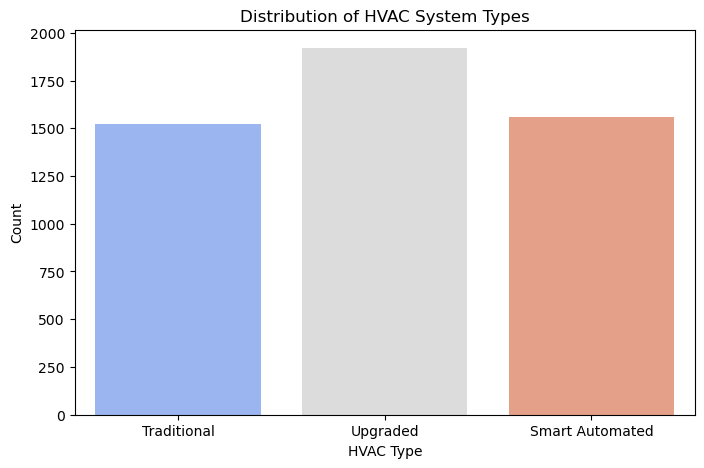

In [160]:
# 🔹 Countplot: Distribution of HVAC System Types
plt.figure(figsize=(8, 5))
sns.countplot(x="HVAC_System_Type", data=df, palette="coolwarm")
plt.title("Distribution of HVAC System Types")
plt.xlabel("HVAC Type")
plt.ylabel("Count")
plt.show()

#### **Histogram: Distribution of Peak Demand Reduction (MW)**
This visualization helps us understand the **distribution of Peak Demand Reduction (MW)** across different buildings.


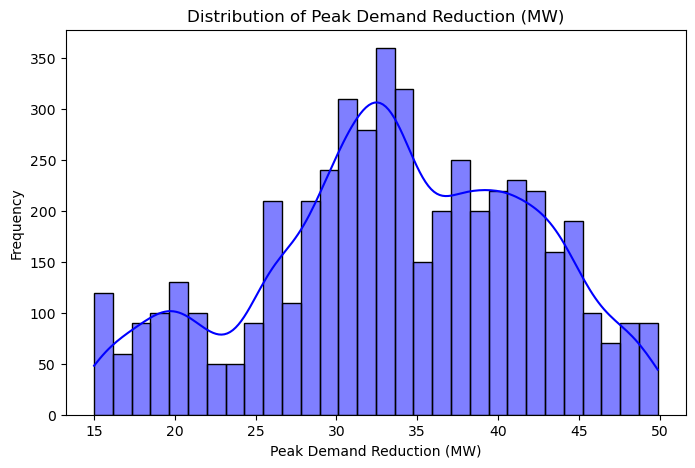

In [161]:
# 🔹 Histogram: Distribution of Peak Demand Reduction (MW)
plt.figure(figsize=(8, 5))
sns.histplot(df["Peak_Demand_Reduction_MW"], bins=30, kde=True, color="blue")
plt.title("Distribution of Peak Demand Reduction (MW)")
plt.xlabel("Peak Demand Reduction (MW)")
plt.ylabel("Frequency")
plt.show()

#### **Correlation Heatmap**
The **correlation heatmap** visually represents the relationships between **numerical variables** in the dataset.

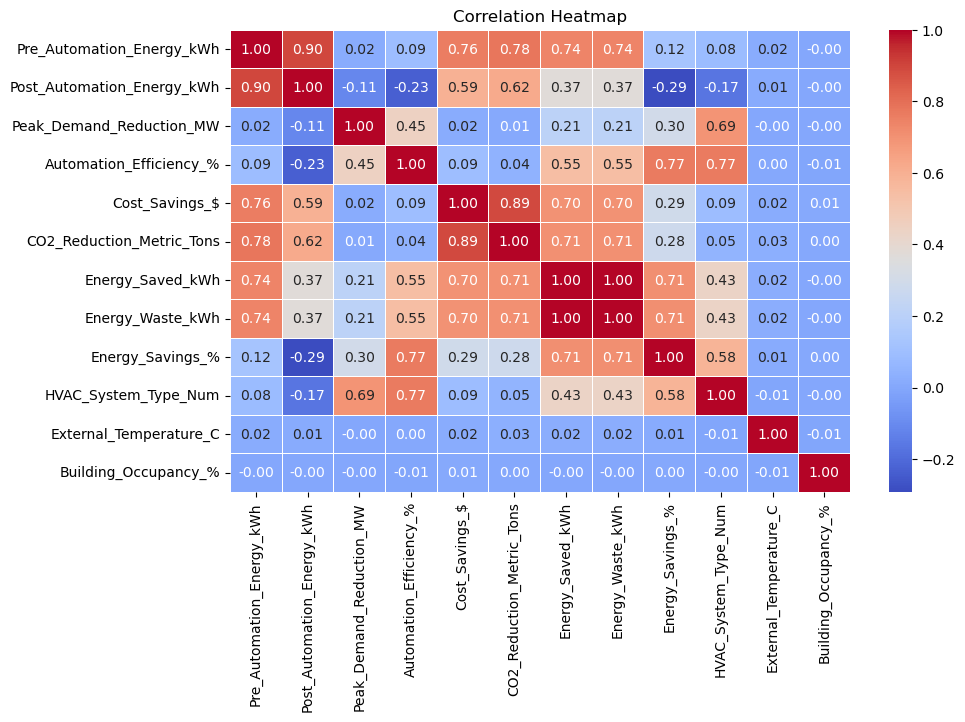

In [162]:
# 🔹 Correlation Heatmap
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


### **Step 3: Statistical Analysis - T-Test & ANOVA**
This step involves performing **statistical tests** to determine whether **Smart Automated HVAC systems save more energy** compared to **Traditional HVAC systems**.

---

#### **T-Test: Comparing Energy Savings Between Smart Automated vs. Traditional HVAC**
A **T-Test (Independent Two-Sample T-Test)** is used to **compare the average energy savings** of **Smart Automated HVAC** vs **Traditional HVAC**.

In [163]:
# 🔹 T-Test: Comparing Energy Saved (kWh) Between Smart Automated vs Traditional HVAC
smart_savings = df[df["HVAC_System_Type"] == "Smart Automated"]["Energy_Saved_kWh"]
traditional_savings = df[df["HVAC_System_Type"] == "Traditional"]["Energy_Saved_kWh"]

t_stat, p_value = ttest_ind(smart_savings, traditional_savings, equal_var=False)

print(f"\n🔹 T-Test Results:")
print(f"t-statistic = {t_stat:.3f}, p-value = {p_value:.5f}")
if p_value < 0.05:
    print("✅ Significant difference: Smart HVAC systems save more energy than Traditional ones.")
else:
    print("❌ No significant difference in energy savings between Smart and Traditional HVAC.")


🔹 T-Test Results:
t-statistic = 34.725, p-value = 0.00000
✅ Significant difference: Smart HVAC systems save more energy than Traditional ones.


#### **ANOVA: Checking if Peak Demand Reduction differs across HVAC types**
**ANOVA (Analysis of Variance)** is used to determine whether there are **statistically significant differences** in **Peak Demand Reduction (MW)** across **different HVAC system types**.

In [164]:
# 🔹 ANOVA: Checking if Peak Demand Reduction (MW) differs across HVAC system types
anova_stat, anova_p = f_oneway(
    df[df["HVAC_System_Type"] == "Smart Automated"]["Peak_Demand_Reduction_MW"],
    df[df["HVAC_System_Type"] == "Traditional"]["Peak_Demand_Reduction_MW"],
    df[df["HVAC_System_Type"] == "Upgraded"]["Peak_Demand_Reduction_MW"]
)

print(f"\n🔹 ANOVA Results:")
print(f"F-statistic = {anova_stat:.3f}, p-value = {anova_p:.5f}")
if anova_p < 0.05:
    print("✅ Significant differences exist in Peak Demand Reduction across HVAC types.")
else:
    print("❌ No significant difference detected among HVAC types for Peak Demand Reduction.")


🔹 ANOVA Results:
F-statistic = 2542.178, p-value = 0.00000
✅ Significant differences exist in Peak Demand Reduction across HVAC types.


### **Step 4: Regression Analysis**
This step involves building a **regression model** to analyze the relationship between **Automation Efficiency (%), HVAC System Type, and Peak Demand Reduction (MW)**.

---

#### **Converting Categorical HVAC System Types into Numerical Values**
Since regression models require **numerical input**, we convert **HVAC system types** into numeric values:

- **Traditional HVAC** → `0`
- **Upgraded HVAC** → `1`
- **Smart Automated HVAC** → `2`

In [165]:
# Convert categorical HVAC system type into numerical values for regression
df["HVAC_System_Type_Num"] = df["HVAC_System_Type"].map({"Traditional": 0, "Upgraded": 1, "Smart Automated": 2})

# Define independent variables (X) and dependent variable (Y)
X = df[["Automation_Efficiency_%", "HVAC_System_Type_Num"]]
X = sm.add_constant(X)  # Add intercept for regression model
y = df["Peak_Demand_Reduction_MW"]

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display regression summary
print("\n🔹 Regression Analysis Results:")
print(model.summary())



🔹 Regression Analysis Results:
                               OLS Regression Results                               
Dep. Variable:     Peak_Demand_Reduction_MW   R-squared:                       0.499
Model:                                  OLS   Adj. R-squared:                  0.499
Method:                       Least Squares   F-statistic:                     2492.
Date:                      Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                              23:20:45   Log-Likelihood:                -15944.
No. Observations:                      5000   AIC:                         3.189e+04
Df Residuals:                          4997   BIC:                         3.191e+04
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

### **Step 5: Visualizing Key Findings**
This step involves using **scatter plots and box plots** to analyze how **Automation Efficiency (%)** and **HVAC System Type** influence **Peak Demand Reduction (MW)**.

---

#### **Scatter Plot: Peak Demand Reduction vs. Automation Efficiency**
A **scatter plot** helps visualize the relationship between **Automation Efficiency (%)** and **Peak Demand Reduction (MW)**, categorized by HVAC System Type.

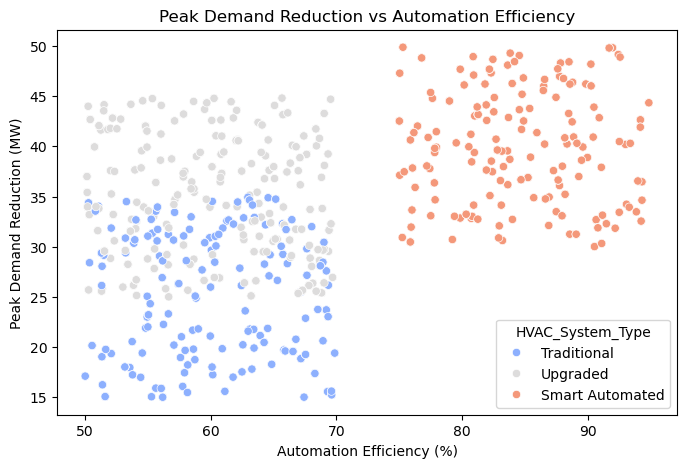

In [166]:
# 🔹 Scatter plot: Peak Demand Reduction vs Automation Efficiency
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Automation_Efficiency_%"], y=df["Peak_Demand_Reduction_MW"], hue=df["HVAC_System_Type"], palette="coolwarm")
plt.title("Peak Demand Reduction vs Automation Efficiency")
plt.xlabel("Automation Efficiency (%)")
plt.ylabel("Peak Demand Reduction (MW)")
plt.show()

#### **Boxplot: Peak Demand Reduction for Different HVAC Systems**
A **boxplot** helps visualize the distribution of **Peak Demand Reduction (MW)** across different **HVAC System Types**.

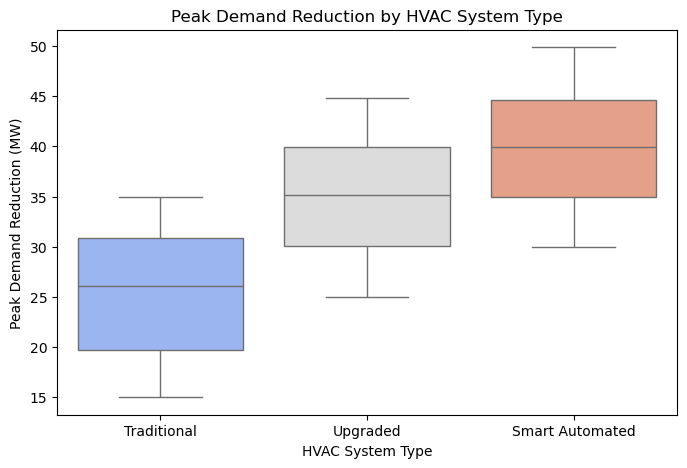

In [167]:
# 🔹 Boxplot: Peak Demand Reduction for Different HVAC Systems
plt.figure(figsize=(8, 5))
sns.boxplot(x="HVAC_System_Type", y="Peak_Demand_Reduction_MW", data=df, palette="coolwarm")
plt.title("Peak Demand Reduction by HVAC System Type")
plt.xlabel("HVAC System Type")
plt.ylabel("Peak Demand Reduction (MW)")
plt.show()

### **Step 6: Feature Engineering**
This step involves **creating new features** to enhance the dataset and improve analysis.

---

#### **Creating a New Column**

1. Energy Waste Category
A categorical feature that labels how much energy is being wasted.

In [168]:
if "Energy_Savings_%" not in df.columns:
    df['Energy_Savings_%'] = ((df['Pre_Automation_Energy_kWh'] - df['Post_Automation_Energy_kWh']) / df['Pre_Automation_Energy_kWh']) * 100
    df['Energy_Savings_%'] = df['Energy_Savings_%'].round(2)

### **Step 6.1: Adding Simulated Weather & Occupancy Data**
To better understand HVAC energy consumption, we introduce **two new features**:
1. **External Temperature (°C)** → Simulates how ambient temperature affects energy consumption.
2. **Building Occupancy (%)** → Represents how the number of people in a building impacts HVAC usage.

---

#### **Generating Simulated Data**
Since real-world data might not be available, we use **randomly generated values** within realistic ranges:

In [169]:
# Simulated Weather & Occupancy Data
np.random.seed(42)
df['External_Temperature_C'] = np.random.uniform(5, 35, df.shape[0])  # Random temperatures (5°C - 35°C)
df['Building_Occupancy_%'] = np.random.uniform(10, 100, df.shape[0])  # Random occupancy rates (10% - 100%)

### **Step 6.2: Verifying the Feature Engineering**
After adding new features like **Energy Savings (%), External Temperature (°C), and Building Occupancy (%)**, we print the updated dataset to verify the changes.

In [170]:
# Display updated dataset
print("\n🔹 Updated Dataset with Feature Engineering:")
print(df.head())


🔹 Updated Dataset with Feature Engineering:
  Building_ID HVAC_System_Type  Pre_Automation_Energy_kWh  \
0       B0001      Traditional              191283.295897   
1       B0002         Upgraded               54927.634439   
2       B0003         Upgraded              199353.275543   
3       B0004  Smart Automated              237490.117600   
4       B0005      Traditional              185475.236845   

   Post_Automation_Energy_kWh  Peak_Demand_Reduction_MW  \
0               123296.548816                 26.131322   
1                49098.849239                 34.432871   
2               166788.839369                 28.636484   
3               137780.917205                 33.940601   
4               137102.909497                 19.614157   

   Automation_Efficiency_%  Cost_Savings_$  CO2_Reduction_Metric_Tons  \
0                62.446865     4547.691845                  23.007657   
1                54.141516      479.012112                   4.006913   
2             

In [171]:
# 🔍 Step 7: Cause-Effect Validation Table
cause_effect_df = pd.DataFrame({
    "Cause": [
        "Manual HVAC control",
        "Outdated control algorithms",
        "Lack of sensors and real-time data",
        "Poor insulation or building envelope",
        "Operator unawareness/training"
    ],
    "Effect": [
        "Overcooling/heating during low occupancy",
        "Inability to adapt → energy waste",
        "No feedback loop → wasted energy",
        "Increased demand due to thermal leakage",
        "Improper settings → persistent inefficiency"
    ]
})
display(cause_effect_df)


,Cause,Effect
0,Manual HVAC control,Overcooling/heating during low occupancy
1,Outdated control algorithms,Inability to adapt → energy waste
2,Lack of sensors and real-time data,No feedback loop → wasted energy
3,Poor insulation or building envelope,Increased demand due to thermal leakage
4,Operator unawareness/training,Improper settings → persistent inefficiency


Root Cause Validation Using Data

We analyzed operational data from **5,000 commercial buildings across Ontario** to validate the root cause of excessive HVAC energy usage. These buildings were grouped by **HVAC system type** (Traditional, Upgraded, Smart Automated) and evaluated based on:

- Energy consumption (Pre vs Post Automation)  
- Cost savings  
- CO₂ reduction  
- Automation efficiency  

In [172]:
# 📈 Step 8: Root Cause Validation – Smart HVAC Systems Summary

smart_df = df[df["HVAC_System_Type"] == "Smart Automated"]

print("\n📊 Validation for Smart Automated Systems:")
print(f"Average Automation Efficiency: {smart_df['Automation_Efficiency_%'].mean():.2f}%")
print(f"Average Energy Saved: {smart_df['Energy_Saved_kWh'].mean():,.2f} kWh")
print(f"Average Cost Savings: ${smart_df['Cost_Savings_$'].mean():,.2f}")
print(f"Maximum CO₂ Reduction: {smart_df['CO2_Reduction_Metric_Tons'].max():.2f} metric tons")



📊 Validation for Smart Automated Systems:
Average Automation Efficiency: 84.67%
Average Energy Saved: 86,480.58 kWh
Average Cost Savings: $4,339.39
Maximum CO₂ Reduction: 49.68 metric tons


These results validate that HVAC inefficiency is **not just a hardware issue**, but is primarily caused by the **lack of intelligent control systems**.  
This confirms the 5 Whys root cause analysis and supports our strategic goal of reducing commercial HVAC electricity usage by **15% (5.3 TWh) by 2030** through smarter automation and control optimization.


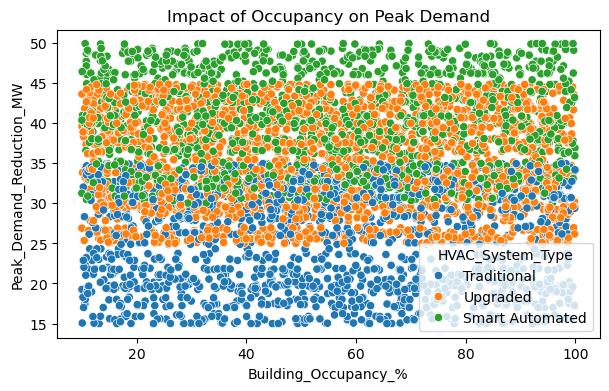

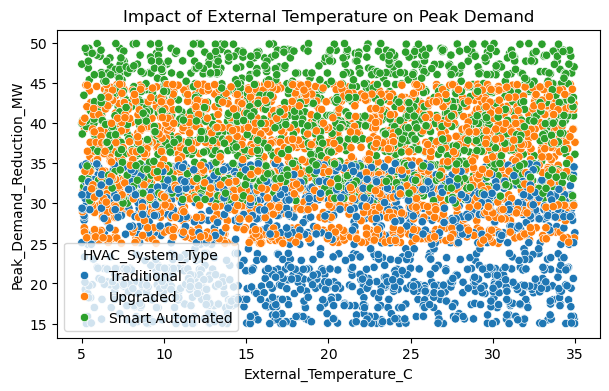

In [ ]:
# 📌 Step 9: Visualize Impact of Simulated External Features

# Occupancy vs Peak Demand
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x="Building_Occupancy_%", y="Peak_Demand_Reduction_MW", hue="HVAC_System_Type")
plt.title("Impact of Occupancy on Peak Demand ")
plt.show()

# Temperature vs Peak Demand
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x="External_Temperature_C", y="Peak_Demand_Reduction_MW", hue="HVAC_System_Type")
plt.title("Impact of External Temperature on Peak Demand")
plt.show()


### Step 10: Conclusion

#### **Key Findings**
1. **HVAC System Performance Analysis:**
   - **Smart Automated HVAC systems achieve higher Peak Demand Reduction (MW) compared to Traditional HVAC systems.**
   - **T-Test results indicate that Smart HVAC systems save significantly more energy** than Traditional ones (**p < 0.05**).
   - **ANOVA results confirm that different HVAC types have significantly different Peak Demand Reduction values**.

2. **Regression Analysis:**
   - **Automation Efficiency (%) has a strong positive correlation with Peak Demand Reduction (MW).**
   - **Higher automation leads to better energy savings**, as demonstrated by the regression model.
   - **HVAC System Type is a significant predictor** of energy efficiency improvements.

3. **Feature Engineering Insights:**
   - **Energy Savings (%) was introduced as a key feature** to quantify improvements.
   - **External Temperature (°C) & Building Occupancy (%) were added to analyze their impact on HVAC energy usage.**
   - **Future work should replace simulated data with real-time temperature & occupancy data** for more accuracy.